<a href="https://colab.research.google.com/github/juneilsam/mariah_carey_christmas/blob/main/mariah_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
import keras.backend as K
from keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
filename = '/content/drive/MyDrive/mariah_xmas.csv'

In [ ]:
df = pd.read_csv(filename, encoding = 'cp949')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3608 non-null   int64  
 1   WDRank  3607 non-null   float64
 2   USRank  3562 non-null   float64
 3   USTemp  3608 non-null   float64
 4   UKRank  3553 non-null   float64
 5   UKTemp  3608 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 169.2 KB


In [ ]:
df.head()

,date,WDRank,USRank,USTemp,UKRank,UKTemp
0,20110219,400.0,400.0,2.78,400.0,5.11
1,20110220,400.0,400.0,-0.78,400.0,4.72
2,20110221,400.0,400.0,-1.33,400.0,5.28
3,20110222,400.0,400.0,-3.72,400.0,6.11
4,20110223,400.0,400.0,-0.56,400.0,8.83


In [ ]:
df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d")
df = df.set_index('date')

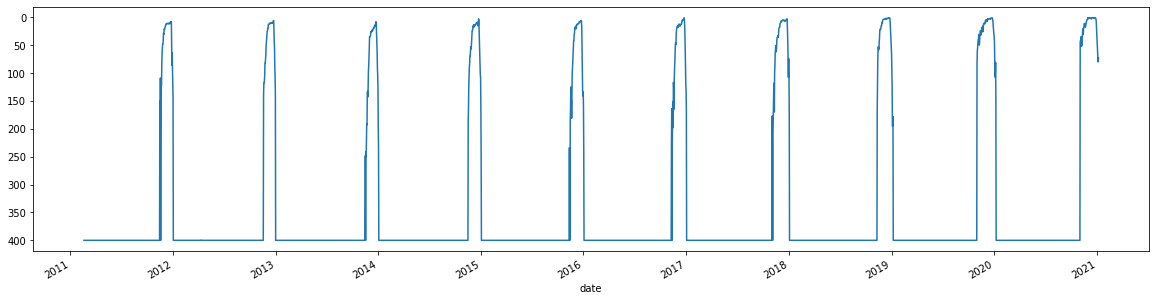

In [ ]:
plt.figure(figsize=(20, 5))
df['WDRank'].plot()
plt.gca().invert_yaxis()

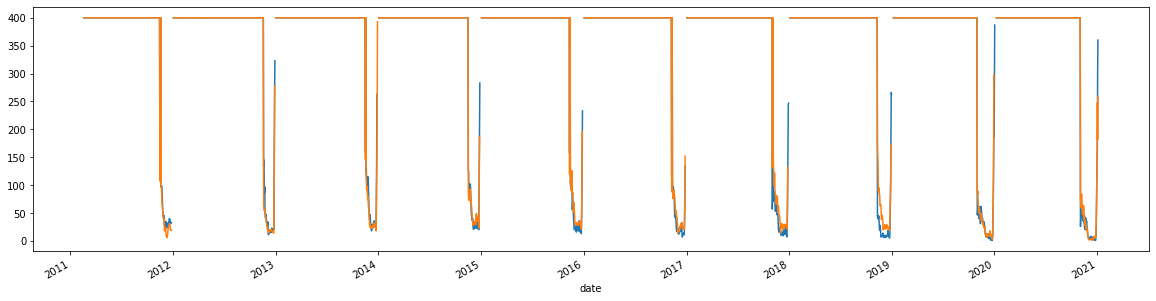

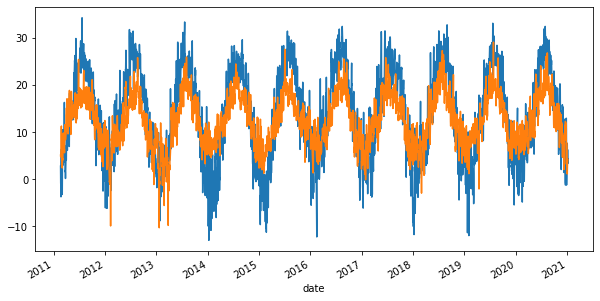

In [ ]:
plt.figure(figsize=(20, 5))
df['USRank'].plot()
df['UKRank'].plot()

plt.figure(figsize=(10, 5))
df['USTemp'].plot()
df['UKTemp'].plot()

In [ ]:
# 결측치는 변경
df = df.fillna(method='pad')

In [ ]:
df.head()

,WDRank,USRank,USTemp,UKRank,UKTemp
date,,,,,
2011-02-19,400.0,400.0,2.78,400.0,5.11
2011-02-20,400.0,400.0,-0.78,400.0,4.72
2011-02-21,400.0,400.0,-1.33,400.0,5.28
2011-02-22,400.0,400.0,-3.72,400.0,6.11
2011-02-23,400.0,400.0,-0.56,400.0,8.83


In [ ]:
df['WDRank'] = pd.to_numeric(df['WDRank'])
df['USRank'] = pd.to_numeric(df['USRank'])
df['UKRank'] = pd.to_numeric(df['UKRank'])

In [ ]:
df = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

In [ ]:
df

,WDRank,USRank,USTemp,UKRank,UKTemp
date,,,,,
2011-02-19,1.000000,1.000000,0.333333,1.000000,0.391205
2011-02-20,1.000000,1.000000,0.257846,1.000000,0.381291
2011-02-21,1.000000,1.000000,0.246183,1.000000,0.395526
2011-02-22,1.000000,1.000000,0.195505,1.000000,0.416624
2011-02-23,1.000000,1.000000,0.262511,1.000000,0.485765
...,...,...,...,...,...
2021-01-02,0.120301,0.744361,0.429813,0.451128,0.289527
2021-01-03,0.165414,0.899749,0.344996,0.646617,0.330452
2021-01-04,0.185464,0.899749,0.407549,0.646617,0.360193


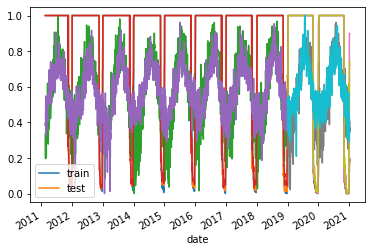

In [ ]:
split_date = pd.Timestamp('2018-12-31')

train = df.loc[:split_date, :]
test = df.loc[split_date: , :]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [ ]:
trainv = train.values
testv = test.values

lookback = 90 # 90일치 데이터로 시퀀스 데이터를 만들기 위함. 50개씩 앞에서부터 자른다는 말임.
X_train = []
X_test = []
y_train = []
y_test = []

# train data 안에서만 생각한다.
for i in range(len(trainv) - lookback): # 90개씩 잘라서 추가한다. (1~50, 2~51, 3~52 ... )
    X_train.append(trainv[i: i + lookback])
    y_train.append(trainv[i + lookback, [0]])

# test data 안에서만 생각한다.
for j in range(len(testv) - lookback): # 90개씩 잘라서 추가한다. (1~50, 2~51, 3~52 ... )
    X_test.append(testv[j: j + lookback])
    y_test.append(testv[j + lookback, [0]])

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2781, 90, 5), (648, 90, 5), (2781, 1), (648, 1))

In [ ]:
# df = df.drop(df[df['WDRank'] == 400].index)

In [ ]:
model = Sequential() # 층층이 차례대로 쌓겠다.

# model.add(BatchNormalization(axis=1, input_shape=X_train.shape[1:]))

model.add(LSTM(90, return_sequences = True, input_shape=(90, 5), activation = 'relu')) # LSTM을 거친다.
model.add(LSTM(64, return_sequences = False, activation = 'relu')) # 한 번 더

model.add(Dense(1, activation='linear')) # 값을 하나 구한다. 예측한 주가
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 90, 90)            34560     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                39680     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 74,305
Trainable params: 74,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

h = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 30, epochs = 200,  callbacks=[early_stop])

Train on 2781 samples, validate on 648 samples
Epoch 1/200
2781/2781 [==============================] - ETA: 0s - loss: 0.0730 - acc: 0.7832

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2781/2781 [==============================] - 11s 4ms/sample - loss: 0.0730 - acc: 0.7832 - val_loss: 0.0096 - val_acc: 0.8256
Epoch 2/200
2781/2781 [==============================] - 10s 4ms/sample - loss: 0.0061 - acc: 0.8569 - val_loss: 0.0087 - val_acc: 0.8256
Epoch 3/200
2781/2781 [==============================] - 10s 4ms/sample - loss: 0.0042 - acc: 0.8576 - val_loss: 0.0097 - val_acc: 0.8256
Epoch 4/200
2781/2781 [==============================] - 10s 4ms/sample - loss: 0.0041 - acc: 0.8583 - val_loss: 0.0081 - val_acc: 0.8256
Epoch 5/200
2781/2781 [==============================] - 10s 4ms/sample - loss: 0.0037 - acc: 0.8580 - val_loss: 0.0075 - val_acc: 0.8256
Epoch 6/200
2781/2781 [==============================] - 10s 4ms/sample - loss: 0.0037 - acc: 0.8583 - val_loss: 0.0070 - val_acc: 0.8256
Epoch 7/200
2781/2781 [==============================] - 10s 4ms/sample - loss: 0.0035 - acc: 0.8583 - val_loss: 0.0071 - val_acc: 0.8256
Epoch 8/200
2781/2781 [=======================

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Text(0.5, 1.0, 'TT')

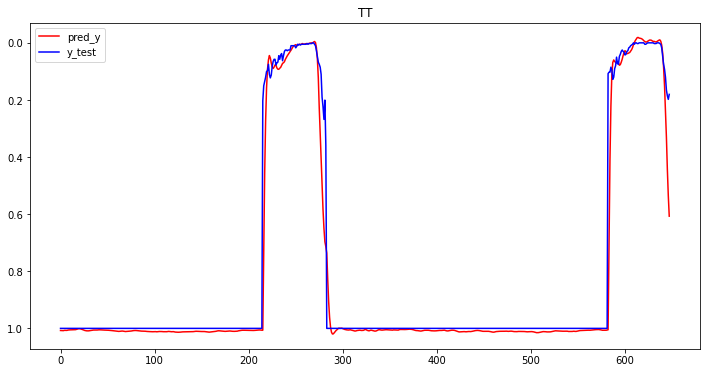

In [ ]:
pred_y = model.predict(X_test)

plt.figure(figsize=[12, 6])
plt.plot(pred_y.ravel(), 'r-', label='pred_y')
plt.plot(y_test.ravel(), 'b-', label='y_test')
plt.gca().invert_yaxis()
plt.legend()
plt.title('TT')

Text(0.5, 1.0, 'Loss')

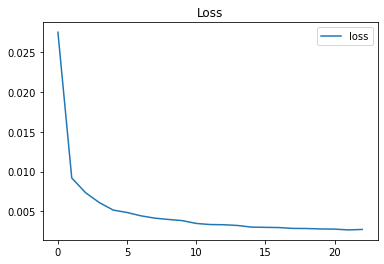

In [ ]:
plt.plot(h.history['loss'], label = 'loss')
plt.legend() # 우측 상단 파란선
plt.title('Loss')